In [1]:
import sys
import os

# Add the project root directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import yaml
from models.contrastive_vae import ContrastiveVAE
from data.data_loader import load_data_from_h5, get_data_loaders


# Load the configuration file
config_path = 'D:/Ziwei/Github/LVAE/config/config.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)



In [3]:
from data.data_loader import save_augmented_data_to_h5
input_filename = 'D:/Ziwei/Github/data/data.h5'
output_filename = 'D:/Ziwei/Github/data/data_aug.h5'
save_augmented_data_to_h5(input_filename, output_filename)

In [4]:
from data.data_loader import save_nor_data_to_h5
input_filename = 'D:/Ziwei/Github/data/data_aug.h5'
output_filename = 'D:/Ziwei/Github/data/data_nor.h5'
save_nor_data_to_h5(input_filename, output_filename)

In [8]:
device = config['device']
experiment_dir = config['experiment_dir']
data_path = config['data']['path']
loader_params = config['loader']
model_params = config['model']['kwargs']
optimizer_params = config['optimizer']['kwargs']
criterion_params = config['criterion']
training_params = config['training']

In [6]:
device = torch.device(device)

In [9]:
from data.data_loader import get_data_loaders_in_memory
train_loader, test_loader = get_data_loaders_in_memory(data_path, batch_size=4)

In [10]:
# Get a batch of data
data_iter = iter(train_loader)
(original_pc, augmented_pc1, augmented_pc2), labels = next(data_iter)
original_pc = original_pc.numpy()
augmented_pc1 = augmented_pc1.numpy()
augmented_pc2 = augmented_pc2.numpy()

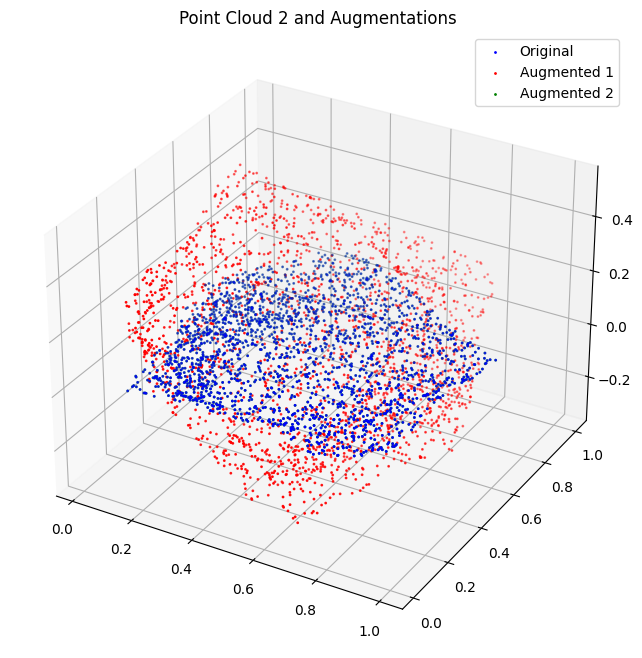

In [12]:
import matplotlib.pyplot as plt  # Correct import
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_clouds_together(original, augmented1, augmented2, idx):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot original point cloud in blue
    ax.scatter(original[:, 2], original[:, 1], original[:, 0], s=1, color='b', label='Original')

    # Plot augmented point cloud 1 in red
    ax.scatter(augmented1[:, 2], augmented1[:, 1], augmented1[:, 0], s=1, color='r', label='Augmented 1')

    # Plot augmented point cloud 2 in green
    ax.scatter(augmented2[:, 2], augmented2[:, 1], augmented2[:, 0], s=1, color='g', label='Augmented 2')

    ax.set_title(f"Point Cloud {idx} and Augmentations")
    ax.legend()
    plt.show()


# Choose an index to visualize
i = 2
# Visualize the point clouds
visualize_point_clouds_together(original_pc[i], augmented_pc1[i], augmented_pc2[i], i)

In [13]:
# Define device based on GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [14]:
import torch
from data.data_loader import get_data_loaders_in_memory

# Configuration values (assuming they are provided in the config dictionary)
data_path = config['data']['path']
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
train_loader, test_loader = get_data_loaders_in_memory(data_path, batch_size=batch_size)

# Print the shape of a batch to verify
for point_clouds, labels in train_loader:
    original_pc, augmented_pc1, augmented_pc2 = point_clouds[0], point_clouds[1], point_clouds[2]
    print(f"Original PC shape: {original_pc.shape}")
    print(f"Augmented PC1 shape: {augmented_pc1.shape}")
    print(f"Augmented PC2 shape: {augmented_pc2.shape}")
    print(f"Labels shape: {labels.shape}")
    break  # Print only one batch

Original PC shape: torch.Size([4, 2048, 3])
Augmented PC1 shape: torch.Size([4, 2048, 3])
Augmented PC2 shape: torch.Size([4, 2048, 3])
Labels shape: torch.Size([4])


In [15]:
from models.contrastive_vae import ContrastiveVAE

# Model parameters (assuming they are provided in the config dictionary)
latent_dim = config['model']['kwargs']['latent_dim']
projection_dim = config['model']['kwargs']['projection_dim']
k = config['model']['kwargs']['k']
emb_dims = config['model']['kwargs']['emb_dims']

# Initialize the model
model = ContrastiveVAE(latent_dim=latent_dim, projection_dim=projection_dim, k=k, emb_dims=emb_dims)
model = model.to(device)

# Print the model structure
print(model)

ContrastiveVAE(
  (encoder): DGCNN(
    (conv1): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv1d(512, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=128, 

In [16]:
for point_clouds, labels in train_loader:
    original_pc, augmented_pc1, augmented_pc2 = point_clouds[0].to(device), point_clouds[1].to(device), point_clouds[2].to(device)
    break  # Use only one batch for debugging

# Pass the batch through the encoder
encoded_features = model.encoder(original_pc)
print(f"Encoded features shape: {encoded_features.shape}")

Encoded features shape: torch.Size([4, 1024])


In [17]:
# Get a batch of data
for point_clouds, labels in train_loader:
    original_pc, augmented_pc1, augmented_pc2 = point_clouds[0].to(device), point_clouds[1].to(device), point_clouds[2].to(device)
    break  # Use only one batch for debugging

# Pass the batch through the encoder
encoded_features = model.encoder(original_pc)
print(f"Encoded features shape: {encoded_features.shape}")

# Check if the dimensions match the expected input of fc_mu and fc_logvar
mu = model.fc_mu(encoded_features)
logvar = model.fc_logvar(encoded_features)
print(f"mu shape: {mu.shape}")
print(f"logvar shape: {logvar.shape}")

# Perform a full forward pass
reconstructed, mu, logvar, projected = model(original_pc)

# Print the shapes of the outputs
print(f"Reconstructed shape: {reconstructed.shape}")
print(f"mu shape: {mu.shape}")
print(f"logvar shape: {logvar.shape}")
print(f"Projected shape: {projected.shape}")


Encoded features shape: torch.Size([4, 1024])
mu shape: torch.Size([4, 128])
logvar shape: torch.Size([4, 128])
Reconstructed shape: torch.Size([4, 2048, 3])
mu shape: torch.Size([4, 128])
logvar shape: torch.Size([4, 128])
Projected shape: torch.Size([4, 64])


In [18]:
import torch
import torch.nn as nn
# test loss
class ChamferLoss(nn.Module):
    def __init__(self):
        super(ChamferLoss, self).__init__()

    def batch_pairwise_dist(self, x, y):
        bs, num_points_x, points_dim = x.size()
        bs, num_points_y, points_dim = y.size()  # Ensure batch size is consistent
        xx = x.pow(2).sum(dim=-1, keepdim=True)  # [bs, num_points_x, 1]
        yy = y.pow(2).sum(dim=-1, keepdim=True)  # [bs, num_points_y, 1]
        zz = torch.bmm(x, y.transpose(2, 1))  # [bs, num_points_x, num_points_y]
        rx = xx.expand(bs, num_points_x, num_points_y)
        ry = yy.transpose(2, 1).expand(bs, num_points_x, num_points_y)
        P = rx + ry - 2 * zz
        return P

    def forward(self, preds, gts):
        # Ensure that the input dimensions are correct
        assert preds.size(2) == 3 and gts.size(2) == 3, "Inputs must have shape [batch_size, num_points, 3]"
        assert preds.size(1) == gts.size(1), "Inputs must have the same number of points"

        P = self.batch_pairwise_dist(gts, preds)
        mins_pred_to_gt, _ = torch.min(P, 1)  # [bs, num_points_y]
        mins_gt_to_pred, _ = torch.min(P, 2)  # [bs, num_points_x]
        loss_pred_to_gt = torch.mean(mins_pred_to_gt)
        loss_gt_to_pred = torch.mean(mins_gt_to_pred)
        return loss_pred_to_gt + loss_gt_to_pred

# Testing Chamfer Loss with random point clouds
batch_size = 4
num_points = 2048

# Create random point clouds with shape [batch_size, num_points, 3]
random_point_cloud_1 = torch.rand((batch_size, num_points, 3))
random_point_cloud_2 = torch.rand((batch_size, num_points, 3))

# Initialize ChamferLoss
chamfer_loss = ChamferLoss()

# Calculate loss
loss = chamfer_loss(random_point_cloud_1, random_point_cloud_2)

# Print the loss
print(f"Chamfer Loss: {loss.item()}")


Chamfer Loss: 0.004566572606563568


In [ ]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from models.contrastive_vae import ContrastiveVAE
from data.data_loader import get_data_loaders_in_memory
from pytorch_metric_learning import losses

class ChamferLoss(nn.Module):
    def __init__(self):
        super(ChamferLoss, self).__init__()

    def batch_pairwise_dist(self, x, y):
        bs, num_points_x, points_dim = x.size()
        bs, num_points_y, points_dim = y.size()  # Ensure batch size is consistent
        xx = x.pow(2).sum(dim=-1, keepdim=True)  # [bs, num_points_x, 1]
        yy = y.pow(2).sum(dim=-1, keepdim=True)  # [bs, num_points_y, 1]
        zz = torch.bmm(x, y.transpose(2, 1))  # [bs, num_points_x, num_points_y]
        rx = xx.expand(bs, num_points_x, num_points_y)
        ry = yy.transpose(2, 1).expand(bs, num_points_x, num_points_y)
        P = rx + ry - 2 * zz
        return P

    def forward(self, preds, gts):
        # Ensure that the input dimensions are correct
        assert preds.size(2) == 3 and gts.size(2) == 3, "Inputs must have shape [batch_size, num_points, 3]"
        assert preds.size(1) == gts.size(1), "Inputs must have the same number of points"

        P = self.batch_pairwise_dist(gts, preds)
        mins_pred_to_gt, _ = torch.min(P, 1)  # [bs, num_points_y]
        mins_gt_to_pred, _ = torch.min(P, 2)  # [bs, num_points_x]
        loss_pred_to_gt = torch.mean(mins_pred_to_gt)
        loss_gt_to_pred = torch.mean(mins_gt_to_pred)
        return loss_pred_to_gt + loss_gt_to_pred

# Assuming `config` is a dictionary containing your configurations

# Model parameters
latent_dim = config['model']['kwargs']['latent_dim']
projection_dim = config['model']['kwargs']['projection_dim']
k = config['model']['kwargs']['k']
emb_dims = config['model']['kwargs']['emb_dims']
num_points = config['model']['kwargs']['num_points']  # Read from config

# Initialize the model
model = ContrastiveVAE(latent_dim=latent_dim, projection_dim=projection_dim, k=k, emb_dims=emb_dims, num_points=num_points)
model = model.to(device)

# Optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=config['optimizer']['kwargs']['lr'])
criterion = losses.NTXentLoss(temperature=config['criterion']['temperature'])
chamfer_loss = ChamferLoss()

# Tensorboard writer
writer = SummaryWriter(log_dir=config['tensorboard']['log_dir'])

# Training loop for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_vae_loss = 0.0
    total_contrastive_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for iteration, (point_clouds, labels) in enumerate(progress_bar):
        original_pc, augmented_pc1, augmented_pc2 = point_clouds[0].to(device), point_clouds[1].to(device), point_clouds[2].to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        concatenated_batch = torch.cat([augmented_pc1, augmented_pc2], dim=0)
        projected_concatenated = model.fc_projection(model.encoder(concatenated_batch))
        
        batch_size = original_pc.size(0)
        contrastive_labels = torch.arange(batch_size).repeat(2).to(device)
        contrastive_loss = criterion(projected_concatenated, contrastive_labels)
        
        reconstructed, mu, logvar, _ = model(original_pc)
        
        rec_loss = chamfer_loss(reconstructed, original_pc)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        vae_loss = config['loss_weights']['Rec_loss'] * rec_loss + config['loss_weights']['KLD'] * kld
        
        loss = vae_loss + contrastive_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_vae_loss += vae_loss.item()
        total_contrastive_loss += contrastive_loss.item()
        
        progress_bar.set_postfix({
            'Total Loss': total_loss / (iteration + 1),
            'VAE Loss': total_vae_loss / (iteration + 1),
            'Contrastive Loss': total_contrastive_loss / (iteration + 1)
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_vae_loss = total_vae_loss / len(train_loader)
    avg_contrastive_loss = total_contrastive_loss / len(train_loader)
    
    writer.add_scalar('training/total_loss', avg_loss, epoch)
    writer.add_scalar('training/vae_loss', avg_vae_loss, epoch)
    writer.add_scalar('training/contrastive_loss', avg_contrastive_loss, epoch)



In [3]:
from training.train import ShapeTrainer
import yaml


# Initialize and run the trainer
trainer = ShapeTrainer(config)
trainer.run()


Epochs:   3%|▎         | 1/30 [52:52<25:33:12, 3172.17s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 1 finished with average loss: 4.465297586984916


Epochs:   7%|▋         | 2/30 [1:45:45<24:40:44, 3173.02s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 2 finished with average loss: 1.3040702727258677


Epochs:  10%|█         | 3/30 [2:37:36<23:35:01, 3144.52s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 3 finished with average loss: 0.9814008995965822


Epochs:  13%|█▎        | 4/30 [3:29:26<22:36:47, 3131.07s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 4 finished with average loss: 0.8703528076904492


Epochs:  17%|█▋        | 5/30 [4:21:16<21:41:23, 3123.35s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 5 finished with average loss: 0.7671194631071854


Epochs:  20%|██        | 6/30 [5:13:06<20:47:32, 3118.86s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 6 finished with average loss: 0.7125384100452978


Epochs:  23%|██▎       | 7/30 [6:04:56<19:54:27, 3115.97s/it]

Epoch 7 finished with average loss: 0.6852291226601893


Epochs:  27%|██▋       | 8/30 [6:56:48<19:02:05, 3114.79s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 8 finished with average loss: 0.6694324859888672


Epochs:  30%|███       | 9/30 [7:48:40<18:09:50, 3113.84s/it]

Epoch 9 finished with average loss: 0.6582015956445143


Epochs:  33%|███▎      | 10/30 [8:40:32<17:17:47, 3113.36s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 10 finished with average loss: 0.6506699884376168


Epochs:  37%|███▋      | 11/30 [9:32:23<16:25:38, 3112.57s/it]

Epoch 11 finished with average loss: 0.6432706171132372


Epochs:  40%|████      | 12/30 [10:24:15<15:33:41, 3112.33s/it]

Epoch 12 finished with average loss: 0.6371103580469009


Epochs:  43%|████▎     | 13/30 [11:16:09<14:41:55, 3112.69s/it]

Epoch 13 finished with average loss: 0.6363431183786468


Epochs:  47%|████▋     | 14/30 [12:08:01<13:49:59, 3112.48s/it]

Epoch 14 finished with average loss: 0.6338813418609768


Epochs:  50%|█████     | 15/30 [12:59:54<12:58:12, 3112.82s/it]

Epoch 15 finished with average loss: 0.6259690838575191


Epochs:  53%|█████▎    | 16/30 [13:51:45<12:06:12, 3112.32s/it]

Epoch 16 finished with average loss: 0.6306975283378651


Epochs:  57%|█████▋    | 17/30 [14:43:38<11:14:21, 3112.44s/it]

Epoch 17 finished with average loss: 0.6220674195819049


Epochs:  60%|██████    | 18/30 [15:35:31<10:22:32, 3112.68s/it]

Epoch 18 finished with average loss: 0.621011639543807


Epochs:  63%|██████▎   | 19/30 [16:27:25<9:30:44, 3113.13s/it] 

Epoch 19 finished with average loss: 0.6199493041894552


Epochs:  67%|██████▋   | 20/30 [17:19:17<8:38:45, 3112.57s/it]

Epoch 20 finished with average loss: 0.6182945905182116


Epochs:  70%|███████   | 21/30 [18:11:08<7:46:51, 3112.34s/it]

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 21 finished with average loss: 0.6151591774492532


Epochs:  73%|███████▎  | 22/30 [19:03:03<6:55:02, 3112.86s/it]

Epoch 22 finished with average loss: 0.6142501230023281


Epochs:  77%|███████▋  | 23/30 [19:54:54<6:03:05, 3112.28s/it]

Epoch 23 finished with average loss: 0.6108195984887836


Epochs:  80%|████████  | 24/30 [20:46:54<5:11:28, 3114.80s/it]

Epoch 24 finished with average loss: 0.61200195509234


Epochs:  83%|████████▎ | 25/30 [21:38:48<4:19:31, 3114.40s/it]

Epoch 25 finished with average loss: 0.6092000934015355


Epochs:  87%|████████▋ | 26/30 [22:30:41<3:27:35, 3113.98s/it]

Epoch 26 finished with average loss: 0.6096212374493641


Epochs:  90%|█████████ | 27/30 [23:22:34<2:35:41, 3113.91s/it]

Epoch 27 finished with average loss: 0.6104646721587562


Epochs:  93%|█████████▎| 28/30 [24:15:29<1:44:23, 3131.97s/it]

Epoch 28 finished with average loss: 0.6090505159580201


Epochs:  97%|█████████▋| 29/30 [25:07:22<52:06, 3126.28s/it]  

Best model checkpoint saved at ./experiments_1/checkpoints\best_ckpt.pt
Epoch 29 finished with average loss: 0.6054997925631159


Epochs: 100%|██████████| 30/30 [25:59:12<00:00, 3118.43s/it]

Epoch 30 finished with average loss: 0.6078574542012589


In [4]:
checkpoint_path = 'D:/Ziwei/Github/experiments/checkpoints/ckpt_iter_0.pt'
checkpoint = torch.load(checkpoint_path)

In [7]:
print(f"Epoch: {checkpoint['epoch']}, Iteration: {checkpoint['iteration']}")

Epoch: 15, Iteration: 0


In [5]:
def build_model(config):
    input_dim = config['model']['kwargs']['input_dim']
    latent_dim = config['model']['kwargs']['latent_dim']
    projection_dim = config['model']['kwargs']['projection_dim']
    k = config['model']['kwargs']['k']
    emb_dims = config['model']['kwargs']['emb_dims']

    model = ContrastiveVAE(input_dim=input_dim, latent_dim=latent_dim, projection_dim=projection_dim, k=k, emb_dims=emb_dims)
    return model



model = build_model(config)
optimizer_class = getattr(torch.optim, config['optimizer']['name'])
optimizer = optimizer_class(model.parameters(), **config['optimizer']['kwargs'])

# Load checkpoint

if checkpoint:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

# Test print model state dict keys
print("Model state dict keys:")
print(model.state_dict().keys())

Model state dict keys:
odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.conv2.weight', 'encoder.bn2.weight', 'encoder.bn2.bias', 'encoder.bn2.running_mean', 'encoder.bn2.running_var', 'encoder.bn2.num_batches_tracked', 'encoder.conv3.weight', 'encoder.bn3.weight', 'encoder.bn3.bias', 'encoder.bn3.running_mean', 'encoder.bn3.running_var', 'encoder.bn3.num_batches_tracked', 'encoder.conv4.weight', 'encoder.bn4.weight', 'encoder.bn4.bias', 'encoder.bn4.running_mean', 'encoder.bn4.running_var', 'encoder.bn4.num_batches_tracked', 'encoder.conv5.weight', 'encoder.bn5.weight', 'encoder.bn5.bias', 'encoder.bn5.running_mean', 'encoder.bn5.running_var', 'encoder.bn5.num_batches_tracked', 'fc_mu.weight', 'fc_mu.bias', 'fc_logvar.weight', 'fc_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'fc_projection.weight', 'fc_projection.bi